## Prepare imports

In [1]:
import torch
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from models.vae import VanillaVAE
from models.vae import BaseModel as BaseVAE
from models.encoder_sparse import BaseModel as EctEncoder
from layers.ect import EctLayer, EctConfig

from metrics.metrics import get_mse_metrics
from metrics.accuracies import compute_mse_accuracies
from metrics.loss import compute_mse_loss_fn
from layers.directions import generate_directions
from datasets import load_datamodule

DEVICE = "cuda:0"
import pyvista as pv

## Load Models and Data

In [2]:
config = OmegaConf.load("./configs/config_encoder_shapenet_chair_sparse.yaml")
dm = load_datamodule(config.data)


In [3]:
dm = load_datamodule(config.data)

# vae = VAE.load_from_checkpoint("./trained_models/vae_mnist.ckpt").cuda()
encoder = EctEncoder.load_from_checkpoint("./my_logs/ectencoder_shapenet_chair_sparse/version_83/checkpoints/epoch=289-step=334370.ckpt").cuda()



# layer = EctLayer(
#     EctConfig(
#         num_thetas=96,
#         bump_steps=96,
#         normalized=True,
#         device=DEVICE,
#         r=5
#     ),
#     v=generate_u_directions(96, 3, DEVICE),
# )


In [4]:

torch.all(torch.isclose(encoder.loss_layer.v,encoder.layer.v))


tensor(True, device='cuda:0')

In [5]:
preds = []
gt = []
with torch.no_grad():
    for batch in dm.val_dataloader():
        batch.cuda()
        print(batch.x.norm(dim=-1).max())
        # ect = encoder.layer(batch,batch.batch)
        pred = encoder(2*batch.ect.cuda()-1)
        gt.append(batch.x)
        preds.append(pred)

tensor(3.4666, device='cuda:0')
tensor(3.6541, device='cuda:0')
tensor(3.7955, device='cuda:0')
tensor(3.7310, device='cuda:0')
tensor(3.6896, device='cuda:0')
tensor(3.7162, device='cuda:0')
tensor(3.5246, device='cuda:0')
tensor(4.0624, device='cuda:0')
tensor(3.8001, device='cuda:0')
tensor(3.6068, device='cuda:0')
tensor(3.3952, device='cuda:0')
tensor(3.6699, device='cuda:0')
tensor(4.0009, device='cuda:0')
tensor(3.7321, device='cuda:0')
tensor(3.8647, device='cuda:0')
tensor(3.3598, device='cuda:0')
tensor(3.2504, device='cuda:0')
tensor(3.9780, device='cuda:0')
tensor(3.7660, device='cuda:0')
tensor(4.1597, device='cuda:0')
tensor(3.8480, device='cuda:0')
tensor(4.6815, device='cuda:0')
tensor(3.7074, device='cuda:0')
tensor(3.4543, device='cuda:0')
tensor(3.7299, device='cuda:0')
tensor(3.3230, device='cuda:0')
tensor(3.3623, device='cuda:0')
tensor(3.6011, device='cuda:0')
tensor(3.7941, device='cuda:0')
tensor(3.1496, device='cuda:0')
tensor(3.3994, device='cuda:0')
tensor(3

In [6]:
reconstruction = torch.cat(preds).view(-1,2048,3)
ground_truth = torch.cat(gt).view(-1,2048,3).cuda()

In [7]:
reconstruction.shape

torch.Size([662, 2048, 3])

In [8]:
ground_truth.shape

torch.Size([662, 2048, 3])

In [9]:
from kaolin.metrics.pointcloud import chamfer_distance

chamfer_distance(reconstruction,ground_truth).mean()

tensor(0.0991, device='cuda:0')

In [16]:
data_loader = dm.val_dataloader()
for batch_idx, features in enumerate(data_loader):
    if batch_idx==10:
        break


In [17]:
features.cuda()
# ect = encoder.layer(features, features.batch)
ect = features.ect

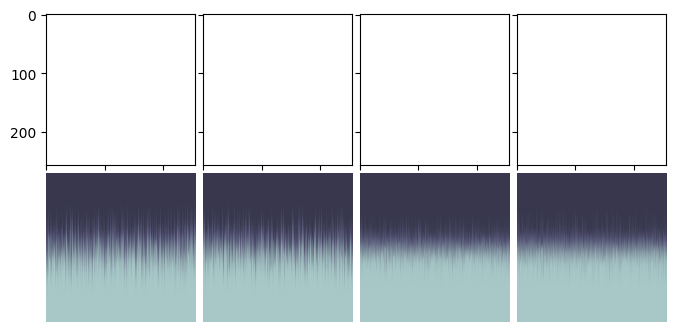

In [18]:
n_images = 4

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(8,4)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for orig_img, ax in zip(ect,axes.T):
    
    
    ax[1].imshow(orig_img.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax[1].axis("off")
    

# plt.savefig("./figures/img/modelnet/reconstructed_ect_vae.svg",transparent=True)

# Original PointClouds

In [19]:
pl = pv.Plotter(shape=(1,4), window_size=[1600,400])

for row in range(1):
    for col in range(4):
        points = features[row*col + col].x.reshape(-1, 3).detach().cpu().numpy()
        pl.subplot(row, col)
        actor = pl.add_points(
            points,
            style="points",
            emissive=False,
            show_scalar_bar=False,
            render_points_as_spheres=True,
            scalars=points[:, 2],
            point_size=2,
            ambient=0.2, 
            diffuse=0.8, 
            specular=0.8,
            specular_power=40, 
            smooth_shading=True
        )


pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10
# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
pl.show()

Widget(value='<iframe src="http://localhost:64834/index.html?ui=P_0x21066290eb0_2&reconnect=auto" class="pyvis…

# Reconstructed PointClouds

In [20]:
with torch.no_grad():
    batch_decoded = encoder.forward(2*ect-1).cpu().detach().numpy()


In [21]:

pl = pv.Plotter(shape=(1,4), window_size=[1600, 400],border=False,polygon_smoothing=True)


for row in range(1):
    for col in range(4):
        points = batch_decoded[row*col + col].reshape(-1, 3)
        pl.subplot(row, col)
        actor = pl.add_points(
            points,
            style="points",
            emissive=False,
            show_scalar_bar=False,
            render_points_as_spheres=True,
            scalars=points[:, 2],
            point_size=2,
            ambient=0.2, 
            diffuse=0.8, 
            specular=0.8,
            specular_power=40, 
            smooth_shading=True
        )


pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10
# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
pl.show()

Widget(value='<iframe src="http://localhost:64834/index.html?ui=P_0x2105245d240_3&reconnect=auto" class="pyvis…

In [16]:



with torch.no_grad():

    recon_batch = ect_encoder_litmodel.model.forward(ect).cpu().detach().numpy()
    recon_batch_vae = ect_encoder_litmodel.model.forward(decoded).cpu().detach().numpy()


pl = pv.Plotter(shape=(2, 4), window_size=[800, 400],border=False,polygon_smoothing=True,off_screen=True)


row = 3
for col in range(4):
    points_vae = recon_batch_vae[row*8 + col].reshape(-1, 3)
    pl.subplot(0, col)
    actor = pl.add_points(
        points_vae,
        style="points",
        emissive=False,
        show_scalar_bar=False,
        render_points_as_spheres=True,
        scalars=points_vae[:, 2],
        point_size=5,
        ambient=0.2, 
        diffuse=0.8, 
        specular=0.8,
        specular_power=40, 
        smooth_shading=True
    )
    points = recon_batch[row*8 + col].reshape(-1, 3)
    pl.subplot(1,  col)
    actor = pl.add_points(
        points,
        style="points",
        emissive=False,
        show_scalar_bar=False,
        render_points_as_spheres=True,
        scalars=points[:, 2],
        point_size=5,
        ambient=0.2, 
        diffuse=0.8, 
        specular=0.8,
        specular_power=40, 
        smooth_shading=True
    )
    


pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10

# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
pl.screenshot("./figures/img/modelnet/reconstructed_vae_pointcloud.png",transparent_background=True,scale=2)
pl.show()
path = pl.generate_orbital_path(n_points=64, shift=2, factor=3.0)
pl.open_gif("./figures/img/modelnet/orbit_vae_cloud.gif")
pl.orbit_on_path(path, write_frames=True)
pl.close()


NameError: name 'ect_encoder_litmodel' is not defined

# Reconstruct the pointcloud with a VAE

In [ ]:
vae_model = VanillaVAE(in_channels=1, latent_dim=64,img_size=config.layer.ect_size)






# Load the VAE model

metrics = get_mse_metrics()

vae_litmodel = BaseVAE.load_from_checkpoint(
    f"./trained_models/vae_shapenet_{config.data.categories[0]}.ckpt",
    model=vae_model,
    training_accuracy=metrics[0],
    test_accuracy=metrics[1],
    validation_accuracy=metrics[2],
    accuracies_fn=compute_mse_accuracies,
    loss_fn=compute_mse_loss_fn,
    learning_rate=0.01,
    layer=layer,
).to(DEVICE)

vae_litmodel.eval()

BaseModel(
  (training_accuracy): MeanSquaredError()
  (validation_accuracy): MeanSquaredError()
  (test_accuracy): MeanSquaredError()
  (model): VanillaVAE(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
      )
      (4): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (fc_mu): Linear(in_features=460

In [ ]:
print(ect.min())
print(ect.max())

tensor(0., device='cuda:0')
tensor(1., device='cuda:0')


In [ ]:

ect = ect * 2 - 1


with torch.no_grad():
    decoded, theinput, z_mean, z_log_var = vae_litmodel.forward(ect)

# Undo the VAE transform
decoded = (decoded + 1 ) / 2
ect = (ect + 1 ) / 2




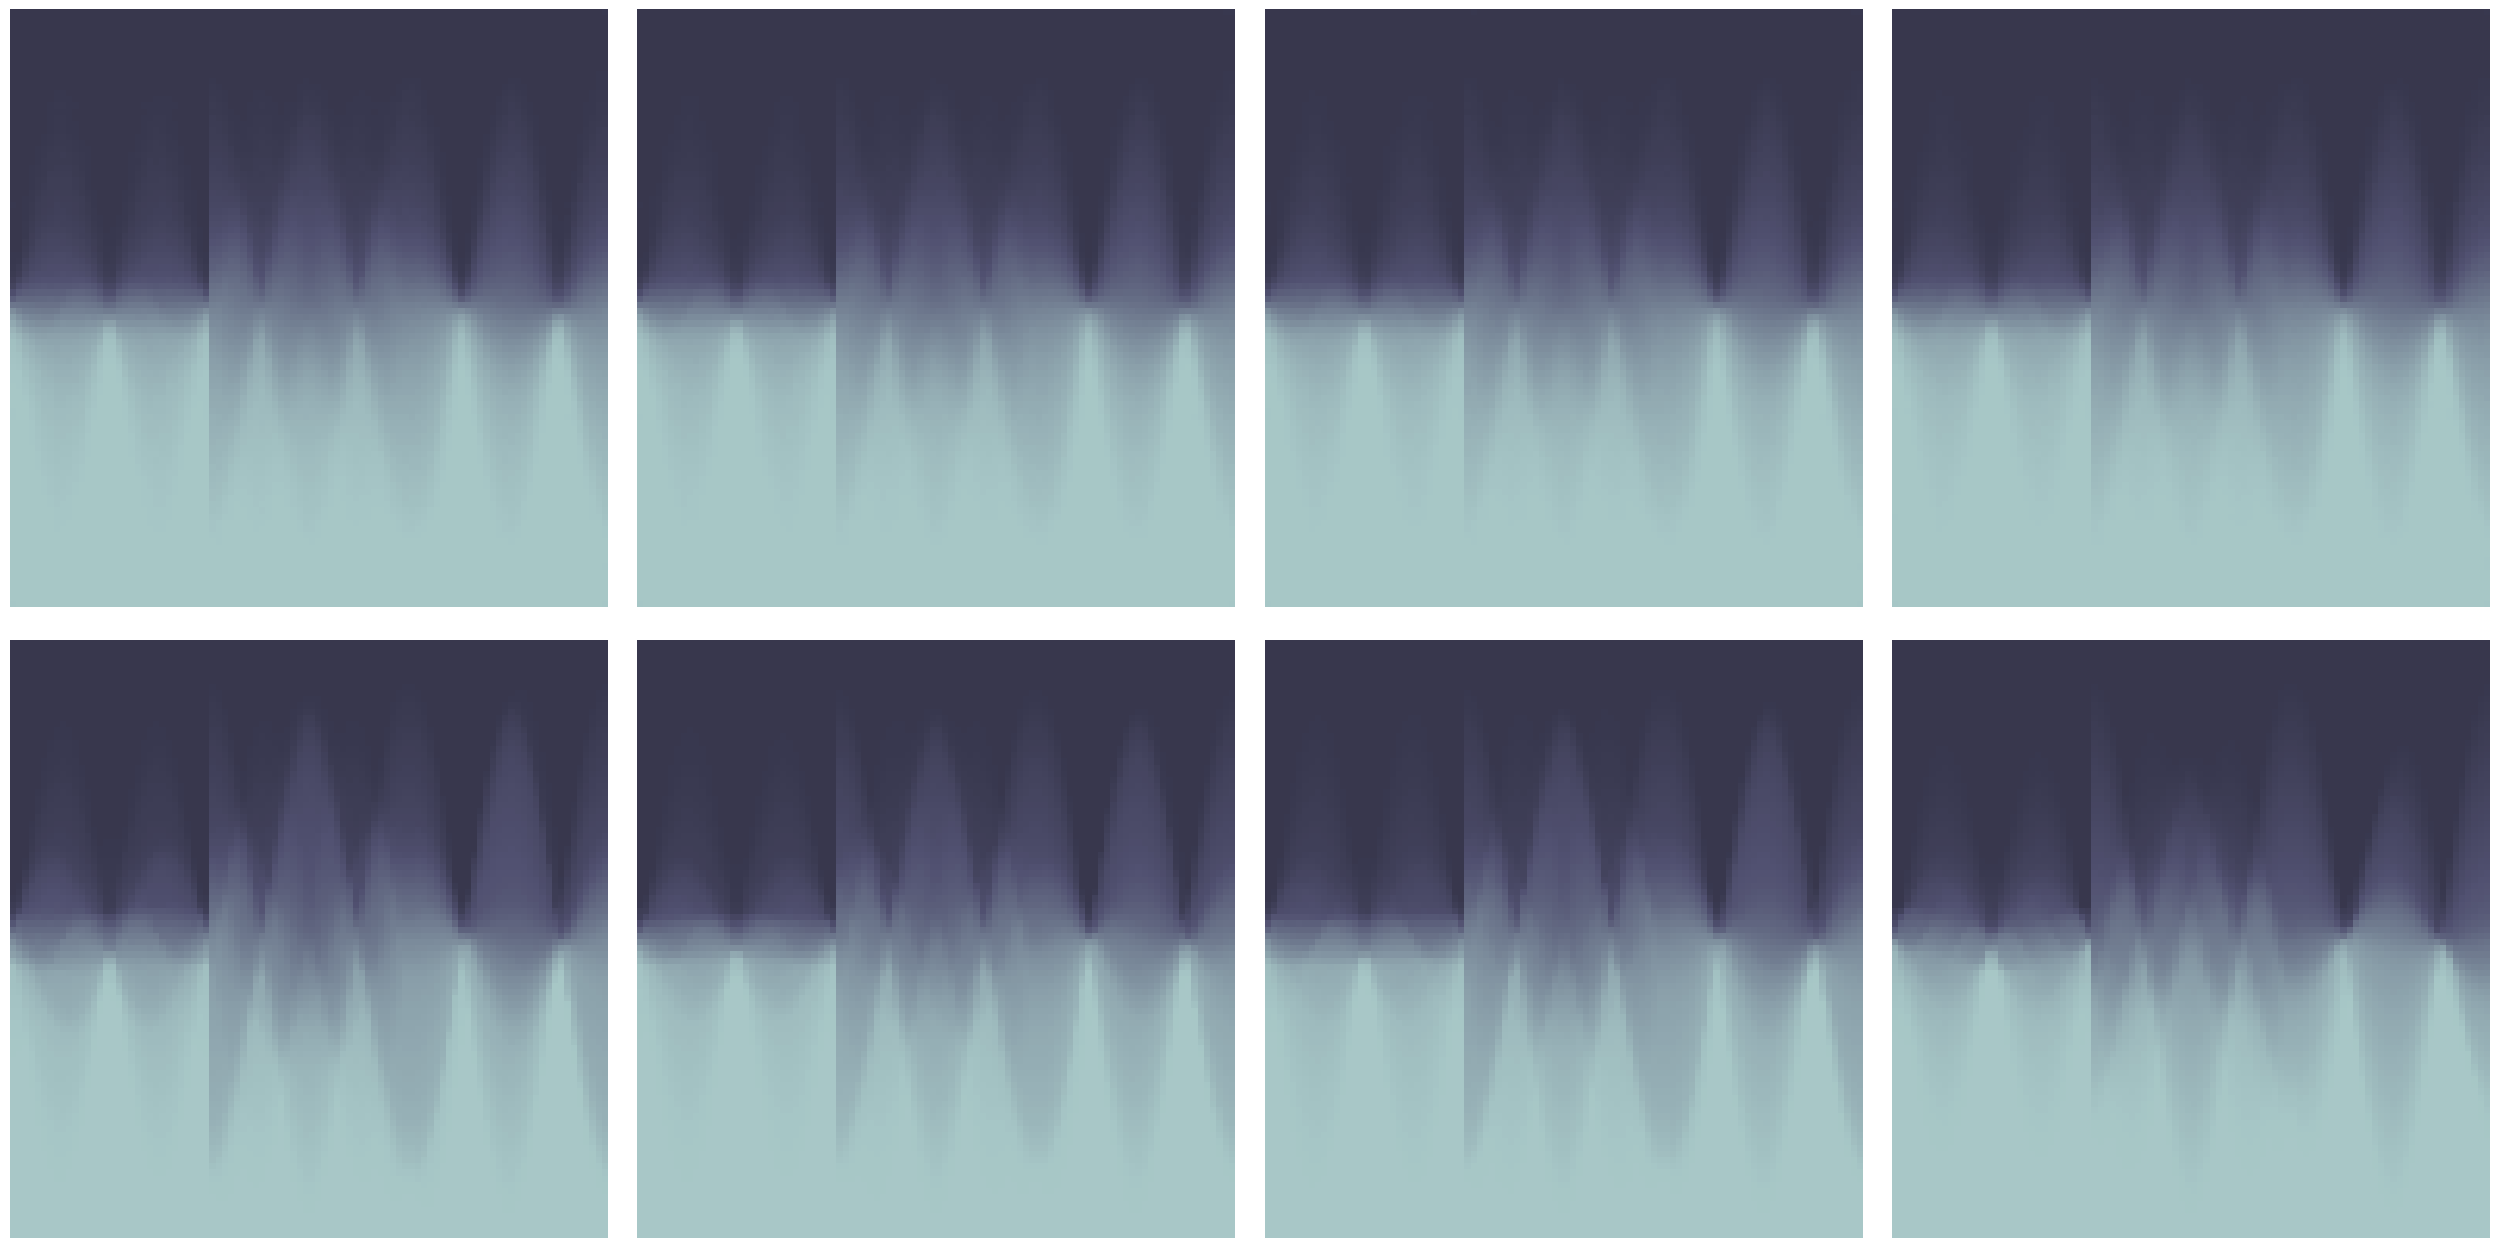

In [ ]:
n_images = 4

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(32,16)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for orig_img, recon_img,ax in zip(ect,decoded,axes.T):
    # print(orig_img.min(),orig_img.max())
    ax[0].imshow(recon_img.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax[0].axis("off")
    ax[1].imshow(orig_img.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax[1].axis("off")

In [ ]:
import torch.nn.functional as F 


F.mse_loss(ect,decoded)

tensor(0.0005, device='cuda:0')

In [ ]:
print(decoded.min())
print(decoded.max())

tensor(2.6822e-07, device='cuda:0')
tensor(1.0000, device='cuda:0')


Widget(value='<iframe src="http://localhost:55453/index.html?ui=P_0x23c276c4820_2&reconnect=auto" class="pyvis…

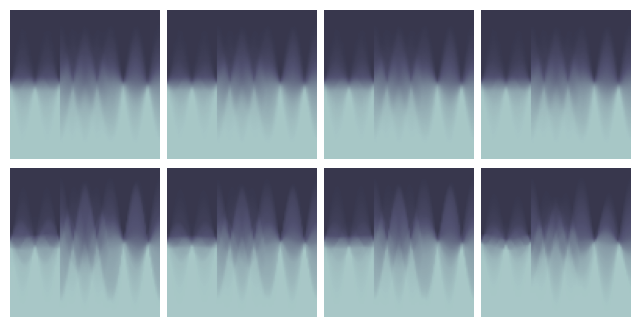

In [ ]:
# data_loader = dm.val_dataloader()
# for batch_idx, features in enumerate(data_loader):
#     break

# features.to(DEVICE)
# ect = layer(features,features.batch).unsqueeze(1)

# with torch.no_grad():
#     decoded, theinput, z_mean, z_log_var = vae_litmodel.forward(ect)

# # Undo the VAE transform
# decoded = (decoded + 1 ) / 2


with torch.no_grad():
    recon_batch_vae = ect_encoder_litmodel.model.forward(decoded).cpu().detach().numpy()


pl = pv.Plotter(shape=(8,8), window_size=[1600, 1600],border=False,polygon_smoothing=True)



for row in range(8):
    for col in range(8):
        points = recon_batch_vae[row*col + col].reshape(-1, 3)
        pl.subplot(row, col)
        actor = pl.add_points(
            points,
            style="points",
            emissive=False,
            show_scalar_bar=False,
            render_points_as_spheres=True,
            scalars=points[:, 2],
            point_size=5,
            ambient=0.2, 
            diffuse=0.8, 
            specular=0.8,
            specular_power=40, 
            smooth_shading=True
        )


pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10
# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
pl.show()


n_images = 4

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(8,4)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for orig_img, recon_img,ax in zip(ect,decoded,axes.T):
    
    ax[0].imshow(recon_img.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax[0].axis("off")
    ax[1].imshow(orig_img.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax[1].axis("off")

## Sample from VAE and reconstruct points 

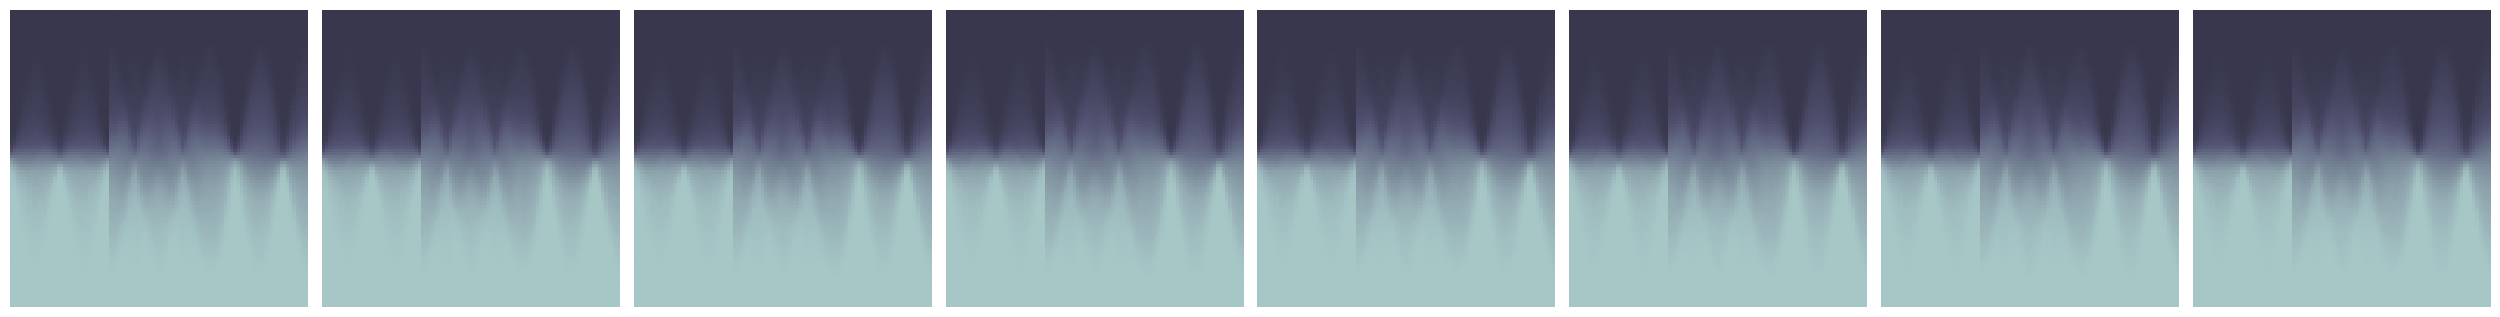

In [ ]:
samples = vae_litmodel.model.sample(64, "cuda:0")
samples = (samples + 1 ) / 2

n_images = 8

fig, axes = plt.subplots(
    nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(32,4)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for sample, ax in zip(samples,axes.T):
    ax.imshow(sample.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax.axis("off")

plt.savefig("./figures/img/modelnet/generated_samples.svg",transparent=True)




In [ ]:

import pyvista as pv

pl = pv.Plotter(shape=(1, 8), window_size=[1600, 200],border=False,polygon_smoothing=True)

with torch.no_grad():
    batch_decoded = ect_encoder_litmodel.model.forward(samples)

batch_decoded = batch_decoded.cpu().detach().numpy()

for col in range(8):
    points = batch_decoded[col].reshape(-1, 3)
    pl.subplot(0,col)
    actor = pl.add_points(
        points,
        style="points",
        emissive=False,
        show_scalar_bar=False,
        render_points_as_spheres=True,
        scalars=points[:, 2],
        point_size=5,
        ambient=0.2, 
        diffuse=0.8, 
        specular=0.8,
        specular_power=40, 
        smooth_shading=True
    )





pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10

# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
pl.screenshot("./figures/img/modelnet/generated_samples.png",transparent_background=True,scale=2)
pl.show()

Widget(value='<iframe src="http://localhost:55453/index.html?ui=P_0x23c276a2260_4&reconnect=auto" class="pyvis…